# Yarkovsky Effect

This example shows how to add the Yarkovsky effect in a Rebound simulation. There are two versions, which we call the 'Full Version' and the 'Simple Version.' A special parameter called 'ye_flag' is used to switch between the two. The difference between the versions and what situations they're better suited for is discussed in more detail below. 

For more information on this effect, please see https://ui.adsabs.harvard.edu/abs/2022ApJS..262...41F/abstract

We'll start with the Full Version.

## Full Version

This version of the effect is based off of the equations found in Veras et al. (2015). A link to the paper is provided below. The Full Version can be used to get detailed calculations of the Yarkovsky effect on a particular body. However, it requires a large amount of parameters that may be difficult to find for a particular object. It also takes more computational time due to the large amount of equations that must be calaculated between each time step of the simulation. This version of the effect can be used to get accurate calculations on how a body is perturbed by the Yarkovsky effect.

Link to paper: https://ui.adsabs.harvard.edu/abs/2015MNRAS.451.2814V/abstract

Below is a simple example to show how to add the effect to a simulation. First, we create a Rebound simulation with the Sun and a test particle (which will be considered an asteroid) at .5 AU.

In [1]:
import rebound
import reboundx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Simulation begins here
sim = rebound.Simulation()

sim.units = ('yr', 'AU', 'Msun') 
sim.integrator = "whfast" 
sim.dt = .05

sim.add(m=1)
sim.add(a=.5, f=0, Omega=0, omega=0, e=0, inc=0, m=0)
sim.move_to_com()

print("\n***INITIAL ORBITS:***")
for orbit in sim.calculate_orbits():
    print(orbit)


***INITIAL ORBITS:***
<rebound.Orbit instance, a=0.5000000000000001 e=1.799893761170345e-16 inc=0.0 Omega=0.0 omega=0.0 f=0.0>


As with all REBOUNDx effects, the parameters must be inputed with the same units as the simulation. In our case, we chose to use AU, Msun and yr. This is an easy place to make mistake with complicated quantities like these. Check out reboundx/ipython_examples/Units.ipynb for useful utilities for making these conversions.

In [2]:
# effect properties
c = 63241.077           # speed of light in AU / yr
stef_boltz = 8.96e-16   # Stefan-Boltzmann constant in Msun / (yr^3 K^4)
lstar = 2.7e-4          # solar luminosity (Energy / time) in (Msun * AU^2 / yr^2 )

# object properties
density = 5.05e6        # 3g/cc in Msun/AU^3
radius = 6.68e-09       # 1 km radius of object in AU
Gamma = 8.72e-10        # thermal inertia of 310 kg/s^(5/2) in Msun / yr^(5/2)
rotation_period = 4.9e-4# 4.3 hr rotation period for object in years
albedo = .017           # albedo of object
emissivity = .9         # emissivity of object
k = .25                 # constant between 0 and 1/4 based on object's rotation. See Veras et al. (2015) for details

We then add the Yarkovsky effect and the required parameters for this version. Importantly, we must set 'ye_flag' to 0 to get the Full Version. Physical constants and the stellar luminosity get added to the effect `yark`

In [3]:
#Loads the effect into Rebound
rebx = reboundx.Extras(sim)
yark = rebx.load_force("yarkovsky_effect")

# We set the effect properties on the effect object:
yark.params["ye_c"] = c 
yark.params["ye_lstar"] = lstar 
yark.params["ye_stef_boltz"] = stef_boltz

Other parameters need to be added to each particle feeling the Yarkovsky effect

In [4]:
# Sets parameters for the particle
ps = sim.particles
ps[1].r = radius #remember radius is not inputed as a Rebx parameter - it's inputed on the particle in the Rebound sim
ps[1].params["ye_flag"] = 0 #setting this flag to 0 will give us the full version of the effect
ps[1].params["ye_body_density"] = density
ps[1].params["ye_albedo"] = albedo
ps[1].params["ye_emissivity"] = emissivity
ps[1].params["ye_k"] = k
ps[1].params["ye_thermal_inertia"] = Gamma
ps[1].params["ye_rotation_period"] = rotation_period

# For this example we assume the object has a spin axis perpendicular to the orbital plane: unit vector = (0,0,1)
ps[1].params["ye_spin_axis_x"] = 0
ps[1].params["ye_spin_axis_y"] = 0
ps[1].params["ye_spin_axis_z"] = 1

rebx.add_force(yark) #adds the force to the simulation

We integrate this system for 100,000 years and print out the difference between the particle's semi-major axis before and after the simulation.

In [5]:
%%time
tmax=100000 # in yrs
Nout = 1000
times = np.linspace(0, tmax, Nout)
a_start = .5 #starting semi-major axis for the asteroid
a = np.zeros(Nout)
for i, time in enumerate(times):
    a[i] = ps[1].a
    sim.integrate(time)
a_final = ps[1].a #semi-major axis of asteroid after the sim    
                      
print("CHANGE IN SEMI-MAJOR AXIS:", a_final-a_start, "AU\n") #prints difference between the initial and final semi-major axes of asteroid

CHANGE IN SEMI-MAJOR AXIS: 1.922647066021632e-05 AU

CPU times: user 1.15 s, sys: 3.08 ms, total: 1.15 s
Wall time: 1.15 s


Text(0, 0.5, 'Change in semimajor axis (AU)')

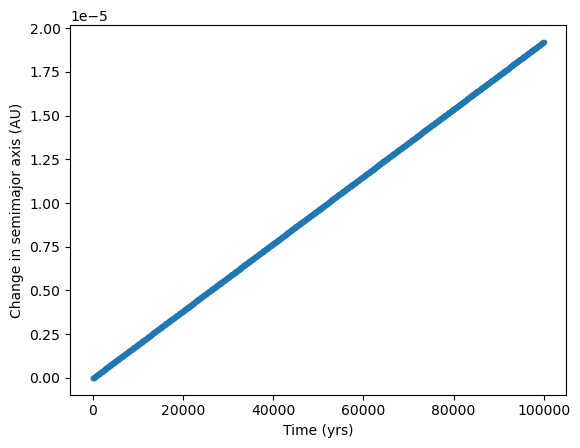

In [6]:
fig, ax = plt.subplots()
ax.plot(times, a-a_start, '.')
ax.set_xlabel('Time (yrs)')
ax.set_ylabel('Change in semimajor axis (AU)')

## Simple Version

This version of the effect is based off of equations from Veras et al. (2019). Once again, a link to this paper is provided below. This version simplifies the equations by placing constant values in a rotation matrix that in general is time-dependent. It requires fewer parameters than the full version and takes less computational time. However, it is mostly useful only to get a general idea on how much the effect can push bodies inwards or outwards. This version of the effect is better for simulating large groups of asteroids or trying to see general trends in the behavior of a body. 

Link to paper: https://ui.adsabs.harvard.edu/abs/2019MNRAS.485..708V/abstract

We'll use the same setup as before, but we'll also add another asteroid at .75 AU with identical physical properties. Let's start by creating a Rebound simulation again.

In [7]:
sim = rebound.Simulation()

sim.units = ('yr', 'AU', 'Msun')
sim.integrator = "whfast"
sim.dt = .05

sim.add(m=1) 
sim.add(a=.5, f=0, Omega=0, omega=0, e=0, inc=0, m=0)
sim.add(a=.75, f=0, Omega=0, omega=0, e=0, inc=0, m=0)
sim.move_to_com()

print("\n***INITIAL ORBITS:***")
for orbit in sim.calculate_orbits():
    print(orbit)


***INITIAL ORBITS:***
<rebound.Orbit instance, a=0.5000000000000001 e=1.799893761170345e-16 inc=0.0 Omega=0.0 omega=0.0 f=0.0>
<rebound.Orbit instance, a=0.75 e=0.0 inc=0.0 Omega=0.0 omega=0.0 f=0.0>


We then add the Yarkovsky effect from Reboundx and the necesary parameters for this version. This time, we must make sure that 'ye_flag' is set to 1 or -1 to get the Simple Version of the effect. Setting it to 1 will push the asteroid outwards, while setting it to -1 will push it inwards. We'll push out our original asteroid and push in our new one. We use the same physical properties as in the example above:

In [8]:
#Loads the effect into Rebound
rebx = reboundx.Extras(sim)
yark = rebx.load_force("yarkovsky_effect")

# We set the effect properties on the effect object:
yark.params["ye_c"] = c
yark.params["ye_lstar"] = lstar

ps = sim.particles
ps[1].params["ye_flag"] = 1 # setting this flag to 1 will give us the outward version of the simple effect 
ps[1].params["ye_body_density"] = density
ps[1].params["ye_albedo"] = albedo
ps[1].r = radius            # remember radius is not inputed as a Rebx parameter

ps[2].params["ye_flag"] = -1 # setting this flag to -1 will give us the inward version of the simple effect 
ps[2].params["ye_body_density"] = density
ps[2].params["ye_albedo"] = albedo
ps[2].r = radius

rebx.add_force(yark) #adds the force to the simulation

Now we run the sim for 100,000 years and print out the results for both asteroids. Note the difference in simulation times between the versions. Even with an extra particle, the simple version was faster than the full version.

In [9]:
%%time
tmax=100000 # in yrs

a_start_1 = .5 #starting semi-major axis for the 1st asteroid
a_start_2 = .75 #starting semi-major axis for the 2nd asteroid

a1, a2 = np.zeros(Nout), np.zeros(Nout)
for i, time in enumerate(times):
    a1[i] = ps[1].a
    a2[i] = ps[2].a
    sim.integrate(time)

a_final_1 = ps[1].a #semi-major axis of 1st asteroid after the sim
a_final_2 = ps[2].a #semi-major axis of 2nd asteroid after the sim
                      
print("CHANGE IN SEMI-MAJOR AXIS(Asteroid 1):", a_final_1-a_start_1, "AU\n")
print("CHANGE IN SEMI-MAJOR AXIS(Asteroid 2):", a_final_2-a_start_2, "AU\n")

CHANGE IN SEMI-MAJOR AXIS(Asteroid 1): 4.1780726372842025e-05 AU

CHANGE IN SEMI-MAJOR AXIS(Asteroid 2): -3.4114924686634573e-05 AU

CPU times: user 1.32 s, sys: 3.54 ms, total: 1.32 s
Wall time: 892 ms


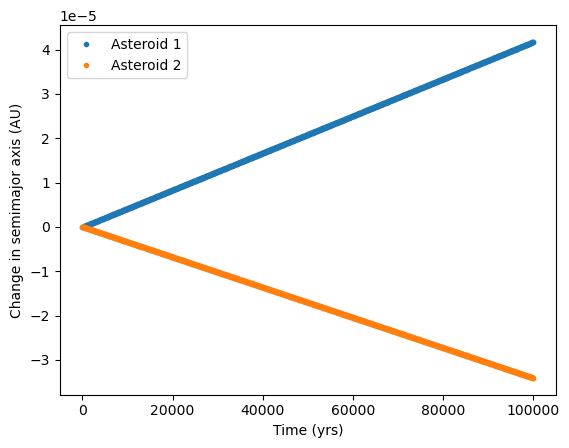

In [10]:
fig, ax = plt.subplots()
ax.plot(times, a1-a_start_1, '.', label='Asteroid 1')
ax.plot(times, a2-a_start_2, '.', label='Asteroid 2')
ax.set_xlabel('Time (yrs)')
ax.set_ylabel('Change in semimajor axis (AU)')
ax.legend()